In [24]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
''' Activation Functions '''

def relu(x, p=False):
    if p: return 1 * (x > 0)
    return x * (x > 0)

def linear(x, p=False):
    if p: return np.ones_like(x)
    return x

In [3]:
''' Cost Functions '''

def MSE(output_acts, y, p=False):
    if p: return (output_acts-y)
    return 0.5*(output_acts-y)**2

In [4]:
''' Optimization Functions '''

def sgd(lr, nabla, cache, alpha=0.9):
    cache = [alpha*c - lr*n for n, c in zip(nabla, cache)]
    update = cache.copy()
    return cache, update

In [15]:
''' Network Class '''

class Network:

    def __init__(self, s=43):
        np.random.seed(s)
        self.layer_cnt = 0
        self.weights = []
        self.biases = []
        self.act_funcs = []
        self.report = dict()
        self.report['loss'] = []
        self.report['re'] = []

    def dense(self, neuron_cnt, act_func, input_shape=None):
        if self.layer_cnt == 0 and (not input_shape):
            raise Exception('First Layer Must Have Input Shape')

        self.layer_cnt += 1

        if self.layer_cnt == 1:
            self.weights.append(np.random.normal(0, 0.05, (neuron_cnt, input_shape)))
        else:
            self.weights.append(np.random.normal(0, 0.05, (neuron_cnt, self.weights[-1].shape[0])))

        self.biases.append(np.zeros((neuron_cnt, 1)))
        self.act_funcs.append(act_func)

    def feedforward(self, x):
        pre_acts, acts = [], []
        act = np.array(x)

        acts.append(act)

        for w, b, a in zip(self.weights, self.biases, self.act_funcs):
            pre_act = np.dot(w, act) + b
            act = a(pre_act)
            pre_acts.append(pre_act)
            acts.append(act)

        return pre_acts, acts, act

    def backprop(self, x, y, cost_func):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        pre_acts, acts, out = self.feedforward(x)

        delta = cost_func(acts[-1], y, p=True) * self.act_funcs[-1](pre_acts[-1], p=True)
        nabla_w[-1] = np.dot(delta, acts[-2].T)
        nabla_b[-1] = delta

        for i in range(2, self.layer_cnt+1):
            delta = np.dot(self.weights[-i+1].T, delta) * self.act_funcs[-i](pre_acts[-i], p=True)
            nabla_w[-i] = np.dot(delta, acts[-i-1].T)
            nabla_b[-i] = delta

        return nabla_w, nabla_b, out

    def next_mini_batch(self, dataset, batch_size):
        N = dataset['count']
        indxs = np.arange(N)
        np.random.shuffle(indxs)

        for i in range(0, N-batch_size+1, batch_size):
            mini_batch = indxs[i:i+batch_size]
            yield zip(dataset['X'][mini_batch], dataset['y'][mini_batch])

    def learn(self, cost_func, epochs, dataset,
            optimizer, eta=0.001, alpha=0.9, batch_size=32,
            verbos=1):

        for i in tqdm(range(epochs), disable=(not verbos)):
            lr = eta/batch_size

            cache_b = [np.zeros(b.shape) for b in self.biases]
            cache_w = [np.zeros(w.shape) for w in self.weights]
            y_, y_h = [], []

            for mini_batch in self.next_mini_batch(dataset, batch_size):
                nabla_b = [np.zeros(b.shape) for b in self.biases]
                nabla_w = [np.zeros(w.shape) for w in self.weights]

                for x, y in mini_batch:
                    delta_nabla_w, delta_nabla_b, out = self.backprop(x, y, cost_func)
                    nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)] 
                    nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
                    y_.append(y)
                    y_h.append(out)

                cache_b, update_b = optimizer(lr, nabla_b, cache_b)
                self.biases = [b+nb for b, nb in zip(self.biases, update_b)]
                cache_w, update_w = optimizer(lr, nabla_w, cache_w)
                self.weights = [w+nw for w, nw in zip(self.weights, update_w)]

            y_, y_h = np.array(y_).ravel(), np.array(y_h).ravel()
            self.report['loss'].append(np.mean(cost_func(y_h, y_)))
            self.report['re'].append(np.mean(np.abs((y_h-y_)/y_)))

            if verbos == 1:
                print('loss: ', self.report['loss'][-1],
                      'reletive error: ', self.report['re'][-1])

    def reset(self):
        self.biases = [np.random.rand(*b.shape) for b in self.biases]
        self.weights = [np.random.rand(*w.shape) for w in self.weights]
        self.report['loss'] = []
        self.report['re'] = []

In [6]:
''' Dataset Functions '''

def make_dataset(N):
    dataset = dict()
    dataset['count'] = N
    dataset['X'] = np.random.uniform(-1, 1, (N, 2, 1))
    dataset['y'] = np.sin(dataset['X'][:, 0]) + np.cos(dataset['X'][:, 1]) 

    return dataset




  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [01:38<13:08, 98.55s/it]


 22%|██▏       | 2/9 [02:58<10:50, 92.88s/it]


 33%|███▎      | 3/9 [04:07<08:34, 85.76s/it]


 44%|████▍     | 4/9 [05:11<06:35, 79.19s/it]


 56%|█████▌    | 5/9 [06:12<04:54, 73.69s/it]


 67%|██████▋   | 6/9 [07:11<03:27, 69.27s/it]


 78%|███████▊  | 7/9 [08:09<02:12, 66.02s/it]


 89%|████████▉ | 8/9 [09:07<01:03, 63.68s/it]


100%|██████████| 9/9 [10:05<00:00, 67.32s/it]


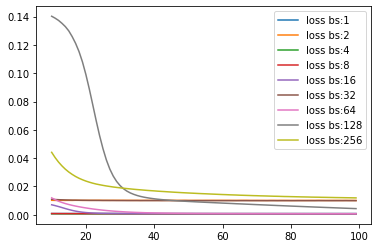

In [23]:
mynet = Network()

mynet.dense(4, relu, 2)
mynet.dense(8, relu)
mynet.dense(1, linear)

mydata = make_dataset(10000)

optimizer = lambda lr, nabla, cache: sgd(lr, nabla, cache, alpha=0.9)

x = np.arange(10, 100)
for bs in tqdm([1, 2, 4, 8, 16, 32, 64, 128, 256]):
    mynet.reset()
    mynet.learn(MSE, 100, mydata, optimizer, eta=0.001, batch_size=bs, alpha=0.9, verbos=0)

    plt.plot(x, mynet.report['loss'][10:], label="loss bs:" + str(bs))

plt.legend()
plt.show()